In [12]:
import gym, gym_unbalanced_disk, time
import numpy as np
from stable_baselines3 import PPO, SAC
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
target_angle=np.pi
reward_fun =  lambda self: ((np.cos(self.th-target_angle)+1.5)*2 - 0.25) + 0.00125*(((np.cos(self.th)+1)/2)*(self.omega)**2) - 0.01*((self.u)**2)


In [3]:
def normalise_angle(theta):
    return ((theta)%(2*np.pi))+np.pi

In [4]:
env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3., reward_fun=reward_fun) 

In [159]:
u_list=[-3]*12+[3]*10+[0]+[-0.9]*3+[0]*100  # sim
# ulist=[-3]*10+[3]*10+[1.5]*3+[-1]*5+[0]*10 # irl

In [161]:
obs = env.reset()
thetas=[]
omegas=[]
rewards=[]
try:
    for u in u_list:
        obs, reward, done, info = env.step(u)
        env.render()
        thetas.append((obs[0]))
        omegas.append(obs[1])
        rewards.append(reward)
        time.sleep(1/50)
        if done:
            obs=env.reset()
finally:
    env.close()

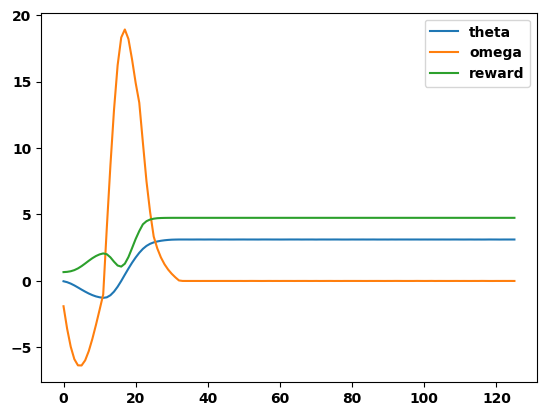

In [8]:
plt.plot(thetas, label='theta')
plt.plot(omegas, label='omega')
plt.plot(rewards, label='reward')
plt.legend()

In [13]:
@dataclass
class Data:
    th = None
    omega = None
    u = None

In [43]:
def normalise_angle(theta):
    return ((theta)%(2*np.pi))-np.pi

def compute_reward(self):
        abs_q=abs(normalise_angle(self.th))
        abs_dq=abs(self.omega)

        # reward
        r = lambda q_, dq_: -(q_**2 + 0.01*dq_**2)
        if abs_q<np.pi*2/3:
            reward= r(abs_q,abs_dq)
        else:
            reward= -(r(np.pi*2/3,4)-1.0*(4.0-abs_dq)**2)

        return reward

In [157]:
def compute_reward(self):
    q=normalise_angle(self.th)
    if abs(q)<np.pi/3:
        return 800 - 0.1*self.omega**2+(self.u/self.omega)**2
    else:
        return q**2+1*self.omega**2+self.u**2+10*(self.u/self.omega)**2

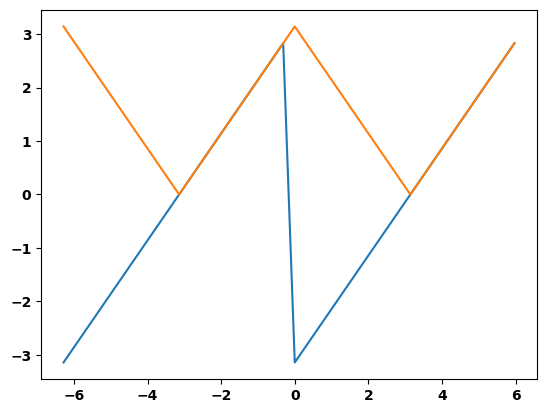

In [114]:
x= np.arange(-2,2,0.1)*np.pi
y= np.apply_along_axis(normalise_angle,0,x)
y2= np.abs(np.apply_along_axis(normalise_angle,0,x))
plt.plot(x,y)
plt.plot(x,y2)

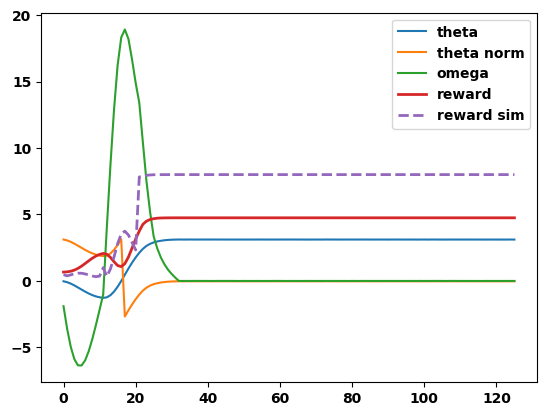

In [158]:
rewards_sim=[]
for i in range(len(u_list)):
    data=Data()
    data.th=thetas[i]
    data.omega=omegas[i]
    data.u=u_list[i]
    rewards_sim.append(compute_reward(data))

rewards_sim=np.array(rewards_sim)
rewards_sim=rewards_sim/100
thetas_norm=np.apply_along_axis(normalise_angle,0,thetas)
plt.plot(thetas, label='theta')
plt.plot(thetas_norm, label='theta norm')
plt.plot(omegas, label='omega')
plt.plot(rewards, linewidth=2, label='reward')
plt.plot(rewards_sim, ls='--', linewidth=2, label='reward sim')
plt.legend()
plt.show()